# CMPE351 - Group 6 - Brain Tumor Classification with a Convolutional Neural Network
##### Authors: Madison Boem, Caroline Kim, Eric Venditti, Jade Watson

This notebook uses a CNN to classify whether an MRI scan of a human brain contains a tumor or not.
This will significantly reduce the amount of time medical professionals spend analyzing scans.
Please see the associated presentation for further elaboration.

The sections included in this script are:
- Importing Libraries
- Data Preprocessing
- Data Splitting
- Model Building
- Model Training
- Model Evaluation

## Importing Libraries

In [92]:
# Tensorflow
from tensorflow.python.keras.layers import Conv2D, Input, ZeroPadding2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

# For image manipulation
import cv2
import imutils

# General
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
%matplotlib inline

## Data Preprocessing

One of the goals of this project is to see how limiting the amount of data preprocessing affects model accuracy.
Hence, varying functions will be created with added or removed preprocessing steps

These are displayed in the table below.

### Image Cropping
MRI scans have a sizeable area that does not include the brain. By reducing unnecessary pixels, we will be able to better approximate whether a scan has a tumor or not.
The cropping technique employed will be to:
1. Perform preliminary pre-processing techniques
2. Find the extreme points in each image (four corners of the brain)
3. Crop and replace the old image

In [93]:
'''
Function to crop just the brain given an MRI scan.

Inputs: MRI scan, decision to plot image or not
Output: Cropped image
'''
def cropImage(image, plot=False):
    # preprocessing necessary for detecting the contour
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Detect the contours (curve joining all the continuous points along the boundary)
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Take the contour with the largest area
    contours = imutils.grab_contours(contours)
    maxContour = max(contours, key=cv2.contourArea)

    # Use argmin and argmax functions to grab the image's extreme points for cropping
    extremeLeft = tuple(maxContour[maxContour[:, :, 0].argmin()][0])
    extremeRight = tuple(maxContour[maxContour[:, :, 0].argmax()][0])
    extremeTop = tuple(maxContour[maxContour[:, :, 1].argmin()][0])
    extremeBottom = tuple(maxContour[maxContour[:, :, 1].argmax()][0])
    
    # Crop the image
    croppedImage = image[extremeTop[1]:extremeBottom[1], extremeLeft[0]:extremeRight[0]]

    # Optionally plot the cropped image
    if(plot):
        # Setup the plot window
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        # Remove increment markings from the plot
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(croppedImage)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    
    return croppedImage

In [94]:
def greyscaleImage(image, plot):
    # Formally convert scan to grayscale (reduces complexity for the CNN)
    # https://blog.roboflow.com/when-to-use-grayscale-as-a-preprocessing-step/
    greyscaledImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if (plot):
        plt.figure()
        plt.imshow(image)
        plt.title('grey image')
    return greyscaledImage

In [95]:
def denoiseImage(image, plot):
    # Blur image (convolves image with low-pass filter kernel)
    # Use Gaussian blurring to reduce Gaussian noise (https://towardsdatascience.com/getting-started-with-tesseract-part-ii-f7f9a0899b3f)
    denoisedImage = cv2.GaussianBlur(image, (5, 5), 0)
    if (plot):
        plt.figure()
        plt.imshow(image)
        plt.title('denoised image')
    return denoisedImage

In [96]:
def thresholdImage(image, plot):
    # Thresholding to make the image "binary" (https://datacarpentry.org/image-processing/07-thresholding/)
    # Reduces complexity and prepares it for the morphology operations
    thresholdedImage = cv2.threshold(image, 45, 255, cv2.THRESH_BINARY)[1]
    if (plot):
        plt.figure()
        plt.imshow(image)
        plt.title('thresholded image')
    return thresholdedImage

In [97]:
def applyImageMorphology(image, plot):
    # Morphological operations to remove imperfections (pairing erosion and dilation):
    # https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html
    # Erosion "erodes" the boundaries of the brain
    erodedImage = cv2.erode(image, None, iterations=2)
    # Dilation accentuates the brains features
    erodedAndDilatedImage = cv2.dilate(erodedImage, None, iterations=2)

    if (plot):
        plt.figure()
        plt.imshow(image)
        plt.title('eroded and dilated image')

    return erodedAndDilatedImage

In [98]:
def normalizeImage(image, plot):
    # normalize so the pixel values are between [0, 1]
    normalizedImage = image / 255
    if (plot):
        plt.figure()
        plt.imshow(image)
        plt.title('normalized image')
    return normalizedImage

Test the above function with one of the images in our dataset

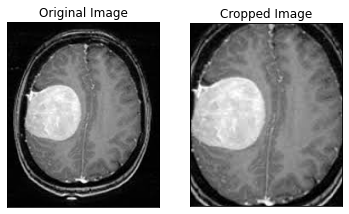

In [99]:
testImage = cv2.imread('yes/Y1.jpg')
testImageCropped = cropImage(testImage, True)

Evidently, the cropping was successful!

### Data Loading

1. Load all of the images in our test set and apply the previously described cropping technique
2. Resize all of the images with dimensions (240, 240, 3) to ensure consistency.
3. Normalize images
4. Pair each image with its corresponding classification (yes/no)
5. Finally, shuffle the images since the "yes"'s and "no"'s are loaded seperately


In [100]:
'''
Function to perform the techniques described above (loading, resizing, normalizing, matching, and shuffling)

Inputs: list containing directories of the images (yes and no folders), image dimensions
Outputs: X (the image set), y (the label set)
'''

def load_data(directoryList, imageSize):
    # initialize image and label arrays
    X = []
    y = []
    # define image width and height
    imageWidth, imageHeight = imageSize

    # iterate over each folder
    for directory in directoryList:
        # iterate over each image in that directory
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)

            # apply various image preprocessing techniques (comment to remove)
            #image = greyscaleImage(image, False)

            #image = thresholdImage(image, False)

            # crop
            image = cropImage(image, False)

            # apply morphology
            #image = applyImageMorphology(image, False)
            # denoise
            #image = denoiseImage(image, False)
            # resize
            image = cv2.resize(image, dsize=(imageWidth, imageHeight), interpolation=cv2.INTER_CUBIC)
            # normalize
            image = normalizeImage(image, False)

            # convert the image to an array (and append to X)
            X.append(image)
            # If the image is in the yes folder, y = 1
            # If the image is in the no folder, y = 0
            if (directory[-3:] == 'yes'):
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)


    # Print statistics about the image and classification set
    numImages = len(X)
    shapeX = X.shape
    shapeY = y.shape

    print(f"Number of examples is: {numImages}")
    print(f"X shape is: {shapeX}")
    print(f"y shape is: {shapeY}")
    
    return X, y

Now, load all of the data using the data loading function
The data will include the augmented data from "CMPE351Group6DataAugmentation.ipynb"

For simplicity, the augmented_path directory contains ALL of the images (including the originals)

In [101]:
# Path to the image dataset
augmented_path = r'C:\Users\ericv\Documents\Winter2022\CMPE351\FinalProject\MohamedAliHabib\augmented'

# Augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + r'\yes'
augmented_no = augmented_path + r'\no'

# Define appropriate image width and height
IMG_WIDTH, IMG_HEIGHT = (340, 340)

# Load the data
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 4379
X shape is: (4379, 340, 340, 3)
y shape is: (4379, 1)


### Plot Some Images
Sanity check to ensure the data was properly loaded and the preprocessing worked successfully.

In [102]:
'''
Function to plot (n) sample images. This is to ensure the data was pro

Inputs: array of images (X), array of classification labels (y), number of images to be plotted (n)
Outputs: none (just plots)
'''
def plot_sample_images(X, y, n):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"{label_to_str(label)} Brain Tumor")
        plt.show()

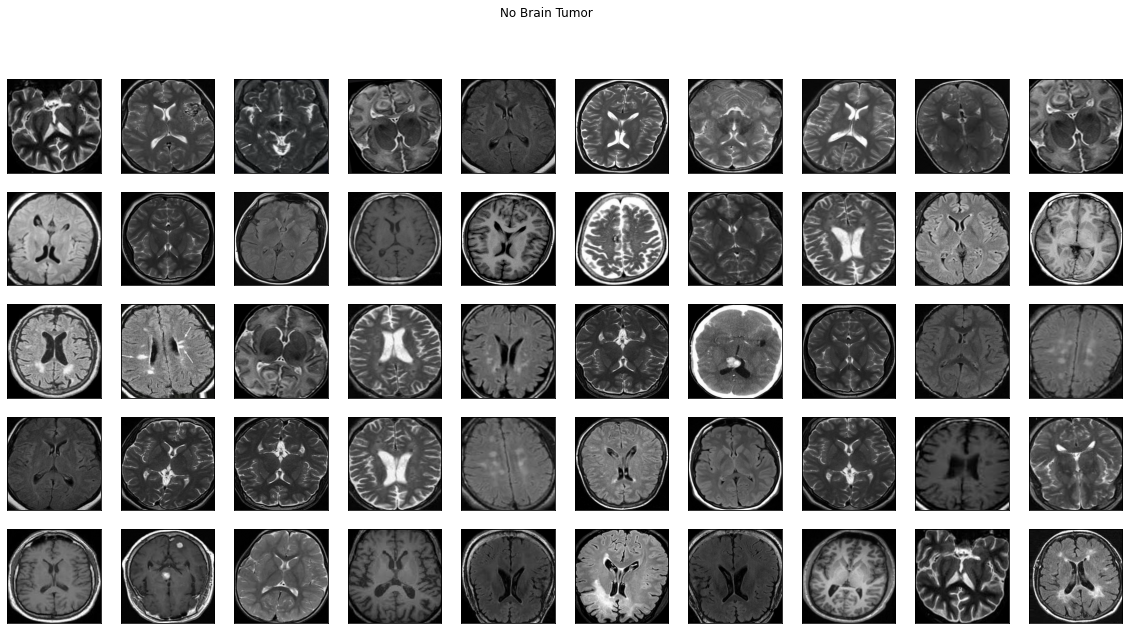

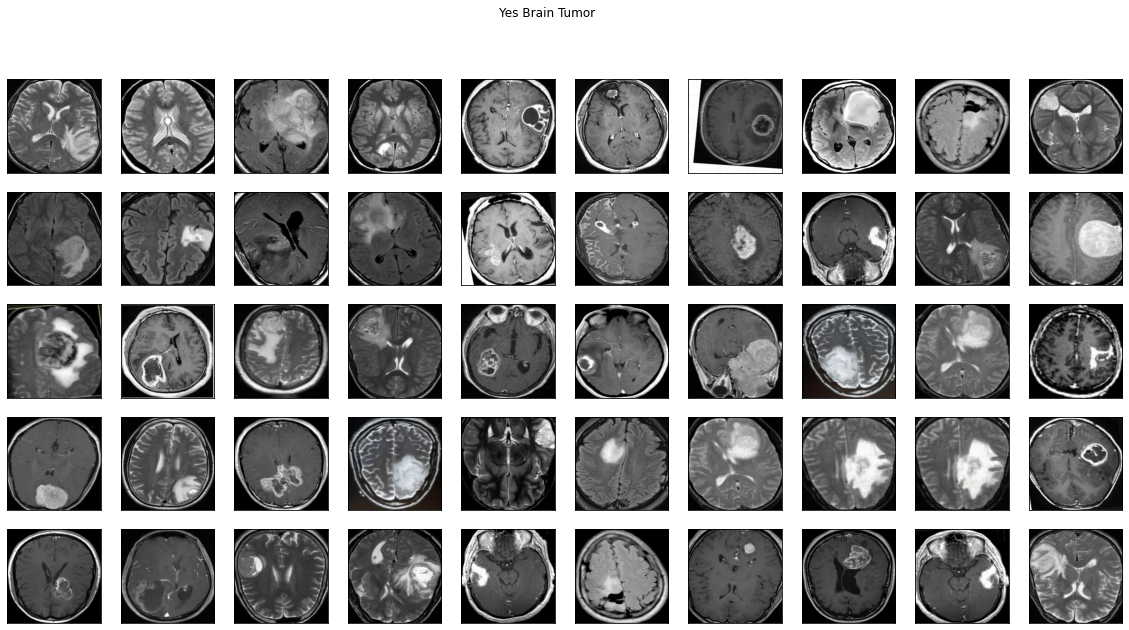

In [103]:
# Plot 50 images
plot_sample_images(X, y, 50)

Clearly, the cropping is successful, and the images are correctly classified.

## Data Splitting

Split X and y into training, testing, and validation sets.

In [104]:
'''
Function to splits the data into training, testing, and validation sets
Inputs: X (image array), y (label array), percentage of images to be in the test set
Outputs: Xtrain, ytrain, Xtest, ytest, Xval, and yval
'''
def split_data(X, y, test_size):

    # Create training and testing sets
    Xtrain, XtestVal, ytrain, ytestVal = train_test_split(X, y, test_size=test_size)
    # Split testing for the validation set (for evaluating the loss and model metrics)
    Xtest, Xval, ytest, yval = train_test_split(XtestVal, ytestVal, test_size=0.5)
    
    return Xtrain, ytrain, Xval, yval, Xtest, ytest

We will use the following (standard) split:
- 80% of the data for training.
- 10% of the data for validation.
- 10% of the data for testing.

In [105]:
# Split and display set sizes
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, 0.2)
print (f"# of training images = {X_train.shape[0]}")
print (f"# of validation images = {X_val.shape[0]}")
print (f"# of test examples = {X_test.shape[0]}")
print (f"Xtrain shape: {X_train.shape}")
print (f"Ytrain shape: {y_train.shape}")
print (f"Xval shape: {X_val.shape}")
print (f"Yval shape: {y_val.shape}")
print (f"Xtest shape: {X_test.shape}")
print (f"Ytest shape: {y_test.shape}")

# of training images = 3503
# of validation images = 438
# of test examples = 438
Xtrain shape: (3503, 340, 340, 3)
Ytrain shape: (3503, 1)
Xval shape: (438, 340, 340, 3)
Yval shape: (438, 1)
Xtest shape: (438, 340, 340, 3)
Ytest shape: (438, 1)


## Model Building
Next, we will create the CNN using the training data

In [106]:
'''
Function to format time
Inputs: seconds elapsed
Outputs: none (just prints formatted timestring)
'''
def hms_string(secElapsed):
    hour = int(secElapsed / (60 * 60))
    minute = int((secElapsed % (60 * 60)) / 60)
    second = secElapsed % 60
    return f"{hour}:{minute}:{round(second,1)}"

In [107]:
'''
Function to calculate f1 score for model evaluation
Inputs: grand truth array, and probabilities
Outputs: f1 Score
'''
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    return score

Function to create a model object. It is especially useful considering we will be testing a number of models.

Expressed Terminology:
- ZeroPadding2D: ensures input sequence has the same length and allows for greater coverage of edge pixels by the CNN
- Conv2D: convolutional layer
- Activation: applies a specified activation function to the output
- ReLu: the activation function (standard, easy to train, has good performance)
- MaxPooling2D: report maximum output in a rectangular neighborhood
- Flatten: flattens the input (does not affect batch size)
- Dense: fully connected layer

In [108]:
'''
Function to create the CNN
Inputs: The shape of the model's input (img width, img height, number of channels)
Outputs: The model object
'''
def build_model(input_shape):
    # Input placeholder (tensor with input_shape input).
    X_input = Input(input_shape) # shape=(None, 240, 240, 3)
    
    # Pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(None, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    # leave out for now ---- X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(None, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(None, 59, 59, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(None, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(None, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(None, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Call the create model function and see its summary for confirmation

In [109]:
imageShape = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(imageShape)
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 340, 340, 3)]     0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 344, 344, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 338, 338, 32)      4736      
_________________________________________________________________
activation_3 (Activation)    (None, 338, 338, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 84, 84, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 21, 21, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 14112)     

Model compilation to define the loss function, optimizer, and metrics.
The 'adam' optimizer and binary cross entropy are standard choices and best in most cases.
We will also be basing the evaluation on accuracy.

In [110]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [111]:
# Define Tensorboard for later visualization
# Name file using time of run for easy retrieval
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [112]:
print()

In [113]:
# Create a model checkpoint so training can be paused/resumed as needed
# create the checkpoint filename
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best metric (accuracy)
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Model Training

Now that the model has been created, training can begin.

We will start with 10 epochs and the default batch size of 32.

In [114]:
# Record the start time
start_time = time.time()

# Train the model for 10 epochs
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# Record the end time adn compute total execution time (hh:mm:ss)
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
110/110 [==============================] - 156s 1s/step - loss: 0.6047 - accuracy: 0.6649 - val_loss: 0.4699 - val_accuracy: 0.8014
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.80.model\assets
Epoch 2/10
110/110 [==============================] - 143s 1s/step - loss: 0.4319 - accuracy: 0.8036 - val_loss: 0.3748 - val_accuracy: 0.8516
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.85.model\assets
Epoch 3/10
110/110 [==============================] - 146s 1s/step - loss: 0.3542 - accuracy: 0.8507 - val_loss: 0.3328 - val_accuracy: 0.8721
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets
Epoch 4/10
110/110 [==============================] - 143s 1s/step - loss: 0.3181 - accuracy: 0.8595 - val_loss: 0.3106 - val_accuracy: 0.8790
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.88.model\assets
Epoch 5/10
110/110 [==============================] - 144s 1s/step -

## Model Evaluation
After training the model, let's look at it's accuracy, loss, and other helpful metrics.

In [115]:
# Access the model history
history = model.history.history

In [116]:
'''
Function to plot model loss and accuracy
Inputs: keras history object
Outputs: none, just plots model loss and accuracy
'''
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

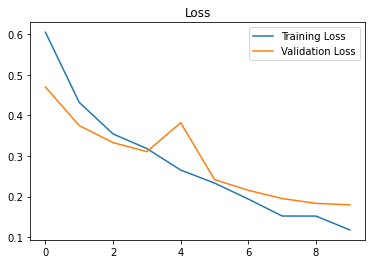

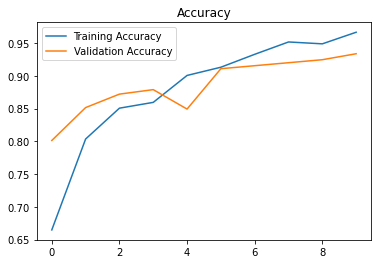

In [117]:
# Display the loss and accuracy plots
plot_metrics(history)

Now, we will load the best model (based on accuracy) and evaluate it based on the testing data

In [118]:
#best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

Evaluate the best model on the testing data:

In [119]:
#loss, acc = best_model.evaluate(x=X_test, y=y_test)

In [120]:
# Display best model loss and accuracy
#print (f"Test Loss = {loss}")
#print (f"Test Accuracy = {acc}")

In [121]:
# Display the best model's f1 score based on the testing data
#y_test_prob = best_model.predict(X_test)
#f1score = compute_f1_score(y_test, y_test_prob)
#print(f"F1 score: {f1score}")

In [122]:
# Display the f1 score based on the validation data
#y_val_prob = best_model.predict(X_val)
#f1score_val = compute_f1_score(y_val, y_val_prob)
#print(f"F1 score: {f1score_val}")

### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [123]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [124]:
# the whole data
data_percentage(y)

Number of examples: 4379
Percentage of positive examples: 53.02580497830555%, number of pos examples: 2322
Percentage of negative examples: 46.97419502169445%, number of neg examples: 2057


In [125]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 3503
Percentage of positive examples: 53.182986011989726%, number of pos examples: 1863
Percentage of negative examples: 46.817013988010274%, number of neg examples: 1640
Validation Data:
Number of examples: 438
Percentage of positive examples: 53.65296803652968%, number of pos examples: 235
Percentage of negative examples: 46.34703196347032%, number of neg examples: 203
Testing Data:
Number of examples: 438
Percentage of positive examples: 51.141552511415526%, number of pos examples: 224
Percentage of negative examples: 48.858447488584474%, number of neg examples: 214


As expectred, the percentage of positive examples are around 50%.